![logo](images/logo-s.png)
# Wowshop Tweet Sentiment Analysis
- Team: Tabitha Berum, Jacinta Chepkemoi, Christine Malinga, Ian Musau
- Course: DSC Hybrid
## Overview
Wowshop, an e-commerce company, operates in a competitive market where customer satisfaction is crucial. Customers frequently tweet about their experiences with ShopEasy, including order issues, product reviews, and customer service interactions. The company wants to enhance its customer service by quickly identifying and addressing customer issues mentioned on Twitter, improving overall service quality, and increasing customer retention.

They have tasked the team with creating a proof of concept that showcases tweet sentiment analysis. The team created a model that can read tweets and assess whether it is positive or otherwise. A simple web app was also developed to showcase the model at work. Upon delivery it will be assessed and the project can move forward.

Problems that surface during development mainly concern the small size of the dataset for training an effective and robust model. With a larger dataset, even better results can be achieved.

<b>Below are screenshots of the demo:</b>
<br><br><br>
![demo1](images/demo1.png)
![demo2](images/demo2.png)

### Technologies
- Python
- NLTK
- Pandas
- Scikit
- Matplotlib
- Seaborn
- FastAPI

## Business Problem
The aim of the project is to create a model that can answer:
- How do customers feel about a product?
- What is the consensus about the storefront?
- Which products are worth restocking and dropping?

## Data Understanding
The training dataset was sourced from the CrowdFlower and is stored in a csv.
1. The dataset contains 9,092 tweets related to the products from Google and Apple.
2. The dataset has 3 features, namely the tweet, the associated product and the emoticon conveyed.



## Data Preparation

Importing relevant libraries

In [312]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from string import punctuation

nltk.download('stopwords')
#warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Loading the Dataset

In [313]:
df=pd.read_csv("judge-1377884607_tweet_product_company.csv",encoding='ISO-8859-1')#since the default encoding used by pandas(utf-8) could not decode the byte in the csv filr
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [314]:
#Checking the Dataset status
class DataFrameChecker:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def check_info(self):
        print("DataFrame Info:")
        self.dataframe.info()

    def check_shape(self):
        print(f"DataFrame Shape: {self.dataframe.shape}")

    def check_describe(self):
        print("DataFrame Description:")
        print(self.dataframe.describe())
    def check_nulls(self):
        print("Null Values in DataFrame:")
        print(self.dataframe.isnull().sum())

    def check_duplicates(self):
        duplicate_rows = self.dataframe[self.dataframe.duplicated()]
        print(f"Number of Duplicate Rows: {duplicate_rows.shape[0]}")
        if duplicate_rows.shape[0] > 0:
            print("Duplicate Rows:")
            print(duplicate_rows)


    # Create an instance of DataFrameChecker
checker = DataFrameChecker(df)

    # Use the methods
print(checker.check_info())
print("---------------------------------------")
print(checker.check_shape())
print("---------------------------------------")
print(checker.check_describe())
print("---------------------------------------")
print(checker.check_nulls())
print("---------------------------------------")
print(checker.check_duplicates())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None
---------------------------------------
DataFrame Shape: (9093, 3)
None
---------------------------------------
DataFrame Description:
                                               tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                

3.1 Data Cleaning "emotion_in_tweet_is_directed_at" Column

In [315]:
df["emotion_in_tweet_is_directed_at"].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

Categorizing the brands to either Apple or Google products

In [316]:
product_category={
    "iPhone":"Apple", 
    "iPad":"Apple",
    "iPad or iPhone App":"Apple", 
    "Other Apple product or service": "Apple",
    "Android":"Google", 
    "Android App":"Google", 
    "Other Google product or service":"Google"
}
df["brand"]=df["emotion_in_tweet_is_directed_at"].replace(product_category)

               
print(df["brand"].value_counts())
print("---------------------------------------")
print(df.info())

brand
Apple     2409
Google     882
Name: count, dtype: int64
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
 3   brand                                               3291 non-null   object
dtypes: object(4)
memory usage: 284.3+ KB
None


Dealing with missing values in the brand column

In [317]:
filtered_df=df[df["brand"].isna()]
filtered_df.head(100)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,NaN
6,NaN,NaN,No emotion toward brand or product,NaN
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,NaN
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,NaN
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,NaN
...,...,...,...,...
186,Currently 150 people in line at the &quot;Pop ...,NaN,No emotion toward brand or product,NaN
187,Only iPad 2 available at #sxsw is the 64GB wif...,NaN,No emotion toward brand or product,NaN
188,÷¼ We love 2 entertain youÛ_Please donÛªt b...,NaN,No emotion toward brand or product,NaN
189,Less than 2 hours until we announce the detail...,NaN,No emotion toward brand or product,NaN


Dropping the 'emotion_in_tweet_is_directed_at' column since the 'brand' column is a replacement of it.

In [318]:
df.drop(columns=['emotion_in_tweet_is_directed_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
 2   brand                                               3291 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


From the filtered_df there are words in the tweet_text column that can help identify the brand.
For example, if the tweet_text contains the word "iPhone," it's likely an Apple brand. Similarly, if the tweet_text contains the word "Android," it's likely a Google brand.

In [319]:
class KeywordBrandAssigner:
    def __init__(self, keyword_to_brand):
        self.keyword_to_brand = keyword_to_brand  # Mapping from keywords to brands

    def assign_brands(self, df):
        for index, row in df.iterrows():
            text = row['tweet_text']
            if pd.isna(row['brand']) and isinstance(text, str):
                text_lower = text.lower()
                for keyword, brand in self.keyword_to_brand.items():
                    if keyword in text_lower:
                        df.at[index, 'brand'] = brand
                        break
        # Fill any remaining NaN values with 'Unknown'
        df['brand'] = df['brand'].fillna('Unknown')

# Example usage
keyword_to_brand = {
    'google': 'Google',
    'apple': 'Apple',
    'ipad': 'Apple',
    'itunes': 'Apple',
    'android': 'Google',
    'iphone': 'Apple'
}

assigner = KeywordBrandAssigner(keyword_to_brand)
assigner.assign_brands(df)


The KeywordBrandAssigner class maps specific keywords to their corresponding brands ("Apple" or "Google") based on the keyword_to_brand dictionary and assigns these brands to the 'brand' column of the DataFrame when a keyword is found in the tweet text. It ensures that any missing or unmatched values in the 'brand' column are filled with "Unknown.

In [320]:
#reloading the dataset
df["brand"].value_counts()

brand
Apple      5440
Google     2946
Unknown     707
Name: count, dtype: int64

Dropped the rows with unknown values since i'm focussed with tweets having information about either Google or Apple

In [321]:
#Dropping records with unknown values in the brand column
df.drop(df[df["brand"] == "Unknown"].index, inplace=True)
df["brand"].value_counts()

brand
Apple     5440
Google    2946
Name: count, dtype: int64

In [322]:
#Reloading the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8386 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8386 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  8386 non-null   object
 2   brand                                               8386 non-null   object
dtypes: object(3)
memory usage: 262.1+ KB


Checking and Dropping of Duplicates

In [323]:
print(df.duplicated().value_counts())
df.drop_duplicates(inplace=True)
print("---------------------------------------")
print(df.shape)

False    8366
True       20
Name: count, dtype: int64
---------------------------------------
(8366, 3)


In [324]:
df.duplicated().value_counts()

False    8366
Name: count, dtype: int64

#### 3.2 Data Cleaning "is there an emotion directed at a brand or product" column.

In [325]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    4688
Positive emotion                      2960
Negative emotion                       568
I can't tell                           150
Name: count, dtype: int64

There are 4 classifiers(no emotion,positive,negative and I can't tell)

I need to consolidate the existing categorical emotions into three distinct classes. Specifically, I will categorize "Positive emotion" as the positive class, the "No emotion toward brand or product," as neutral and  "Negative emotion," as negative. The "I can't tell" records will be treated as missing data and dropped.  This transformation will simplify the classification task and enable the development of an emotion classifier.

In [326]:
Emotions={
    "No emotion toward brand or product":"Neutral",
    "Positive emotion":"Positive",
    "Negative emotion":"Non-Positive",
    "I can't tell":"Unknown"
}
df.loc[:,"is_there_an_emotion_directed_at_a_brand_or_product"] = df["is_there_an_emotion_directed_at_a_brand_or_product"].map(Emotions)
               
print(df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts(normalize=True))


is_there_an_emotion_directed_at_a_brand_or_product
Neutral         0.560363
Positive        0.353813
Non-Positive    0.067894
Unknown         0.017930
Name: proportion, dtype: float64


Dropping the unknowns in the 'is_there_an_emotion_directed_at_a_brand feature

In [327]:
df.drop(df[df["is_there_an_emotion_directed_at_a_brand_or_product"] == "Unknown"].index, inplace=True)
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Neutral         4688
Positive        2960
Non-Positive     568
Name: count, dtype: int64

## EXPLAROTORY DATA ANALYSIS

### Tokenizing

The initial step in preparing the dataset for summarization involves breaking each tweet (currently stored as a text string in the overall table) into individual tokens, separated by commas, and then repopulating each row in the dataframe as a list of tokens. The tokenizer uses a regular expression pattern to split words by non-letter characters while preserving apostrophes within words where relevant. 

Areas of focus  for the preprocessing phase:

i. Tokenizing the tweet texts using 'Tweet Tokenizer' that handles hastages('#') and mentions ('@').

ii. Removing basic Stop Words.

In [328]:
#rename columns for easier usage
df.rename(columns={'tweet_text':'text'}, inplace=True)
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)
df.head()

,text,emotion,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Non-Positive,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive,Apple
3,@sxsw I hope this year's festival isn't as cra...,Non-Positive,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive,Google


#### Tokenizing tweets using the tweet tokenizer

In [329]:
# Initializing Tokenizer
tknzr = TweetTokenizer(strip_handles = True, preserve_case = False, )
df['text'] = df['text'].astype(str).apply(tknzr.tokenize)

df.head()

,text,emotion,brand
0,"[., i, have, a, 3g, iphone, ., after, 3, hrs, ...",Non-Positive,Apple
1,"[know, about, ?, awesome, ipad, /, iphone, app...",Positive,Apple
2,"[can, not, wait, for, #ipad, 2, also, ., they,...",Positive,Apple
3,"[i, hope, this, year's, festival, isn't, as, c...",Non-Positive,Apple
4,"[great, stuff, on, fri, #sxsw, :, marissa, may...",Positive,Google


#### Removing stopwords

In [330]:

# Define the stopwords to remove
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before', '',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', 'youd','youll', 'youre',
             'youve', 'your', 'yours', 'yourself', 'yourselves', '#sxsw', 'sxsw', 'sxswi', '#sxswi', 'rt', 'ipad', 'google', 'apple', 'iphone', 'amp',
             'android', 'sxswi', 'link', '#apple',
             '#google', '...', '\x89', '#ipad2',
             '0','1','2','3','4','5','6','7','8','9',
             '#iphone', '#android', 'store', 'austin', '#ipad']

# Function to remove punctuation and stopwords from a list of tokens
def remove_punctuation_and_stopwords(tokens):
    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', punctuation)) for token in tokens]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwordlist]
    
    return tokens

# Apply the function to the 'text' column
df['text'] = df['text'].apply(remove_punctuation_and_stopwords)

# Print the updated DataFrame
df.head()

,text,emotion,brand
0,"[3g, hrs, tweeting, riseaustin, dead, need, up...",Non-Positive,Apple
1,"[know, awesome, app, likely, appreciate, desig...",Positive,Apple
2,"[not, wait, also, sale]",Positive,Apple
3,"[hope, years, festival, isnt, crashy, years, app]",Non-Positive,Apple
4,"[great, stuff, fri, marissa, mayer, tim, oreil...",Positive,Google


#### Stemming

In [331]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
df['text']= df['text'].apply(lambda x: stemming_on_text(x))
df['text'].head()

0    [3g, hrs, tweeting, riseaustin, dead, need, up...
1    [know, awesome, app, likely, appreciate, desig...
2                              [not, wait, also, sale]
3    [hope, years, festival, isnt, crashy, years, app]
4    [great, stuff, fri, marissa, mayer, tim, oreil...
Name: text, dtype: object

#### Lemmatizing

In [332]:
nltk.download('wordnet')
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Apply the lemmatize_tokens function to the 'text' column of your DataFrame
df['text'] = df['text'].apply(lemmatize_tokens)

# Print the updated DataFrame
df.head()

[nltk_data] Downloading package wordnet to /home/ian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,emotion,brand
0,"[3g, hr, tweeting, riseaustin, dead, need, upg...",Non-Positive,Apple
1,"[know, awesome, app, likely, appreciate, desig...",Positive,Apple
2,"[not, wait, also, sale]",Positive,Apple
3,"[hope, year, festival, isnt, crashy, year, app]",Non-Positive,Apple
4,"[great, stuff, fri, marissa, mayer, tim, oreil...",Positive,Google


#### Viewing most common words in the tweets

In [333]:
# Function for getting the 20 most common words in the tweets
def get_most_common_words(df, column_name):
    tokens = df[column_name].sum()
    fdist = FreqDist(tokens)
    return fdist.most_common(20)

# applying the function
top_words = get_most_common_words(df, 'text')
print(top_words)

[('new', 1036), ('app', 773), ('circle', 651), ('launch', 649), ('popup', 617), ('social', 613), ('today', 522), ('not', 468), ('network', 449), ('line', 432), ('get', 425), ('via', 397), ('party', 346), ('called', 337), ('mobile', 332), ('ipad2', 301), ('one', 300), ('free', 291), ('major', 290), ('time', 284)]


### Visualizations

#### Most common words

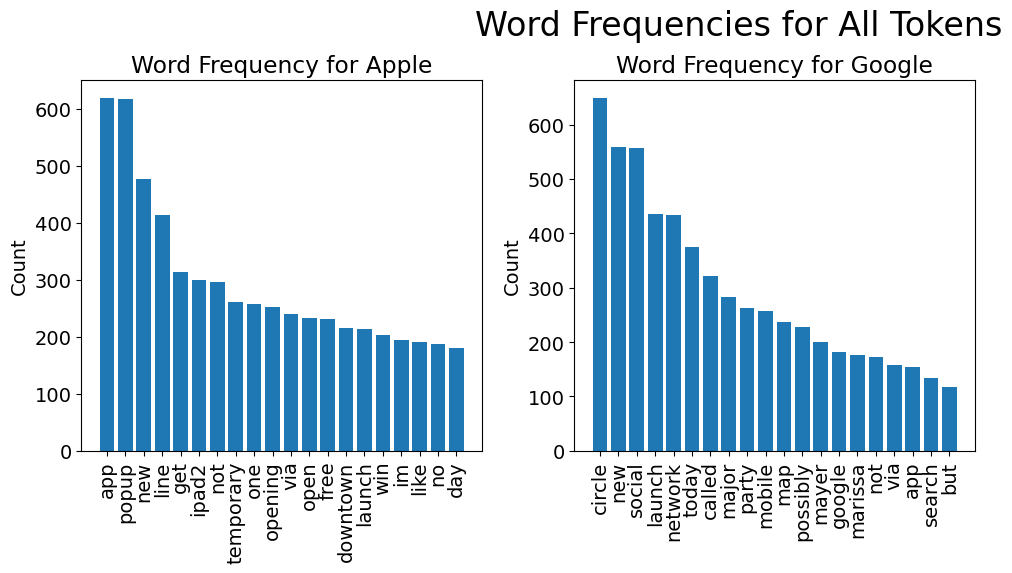

In [334]:
def setup_two_subplots():
    fig = plt.figure(figsize=(15,15))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(3, 6)
    ax1 = fig.add_subplot(gs[0, :2]) 
    ax2 = fig.add_subplot(gs[0, 2:4])
    
    return fig, [ax1, ax2,]

fig, axes = setup_two_subplots()

artnumberdict={'Apple':0,'Google':1,}

def plot_distribution_of_column_by_category(df, axes, title="Word Frequency for"):
    brand_most_common_words={}
    for key, value in artnumberdict.items():
        all_words=df[df["brand"] == key]['text'].explode()
        freq_dist = FreqDist(all_words)
        top_20 = list(zip(*freq_dist.most_common(20)))
        tokens = top_20[0]
        counts = top_20[1]
        ax=axes[value]
        ax.bar(tokens, counts)
        ax.set_title(f"{title} {key}")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=90)
        plt.rcParams.update({'font.size':14})

plot_distribution_of_column_by_category(df, axes)
fig.suptitle("Word Frequencies for All Tokens", fontsize=24);

#### Word Clouds

Separating neutral, negative and positive tweets

In [335]:
df_neg = df[df['emotion'] == 'Non-Positive']
df_pos = df[df['emotion'] == 'Positive']
df_neu = df[df['emotion'] == 'Neutral']

Function that displays word cloud

In [336]:
def tweet_cloud(dataframe):
    tweets = dataframe['text'].explode().str.cat(sep=' ')

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=500, max_font_size=110, background_color="white").generate(tweets)

    # Display the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Negative tweet word cloud

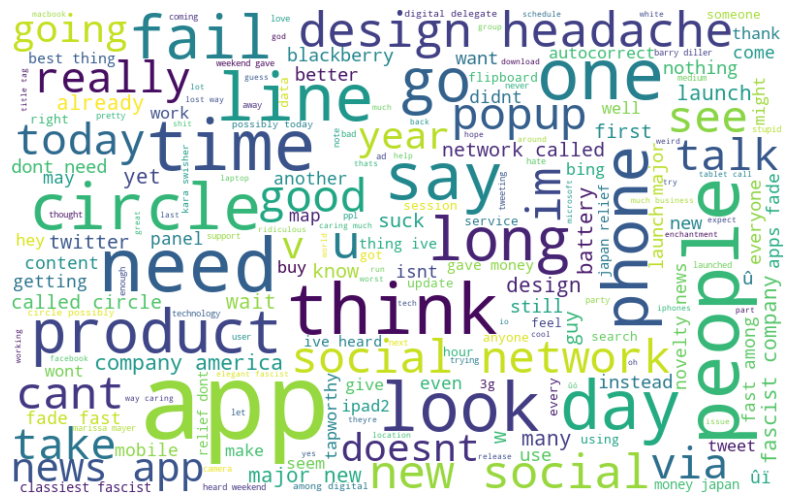

In [337]:
tweet_cloud(df_neg)

Positive tweet word cloud

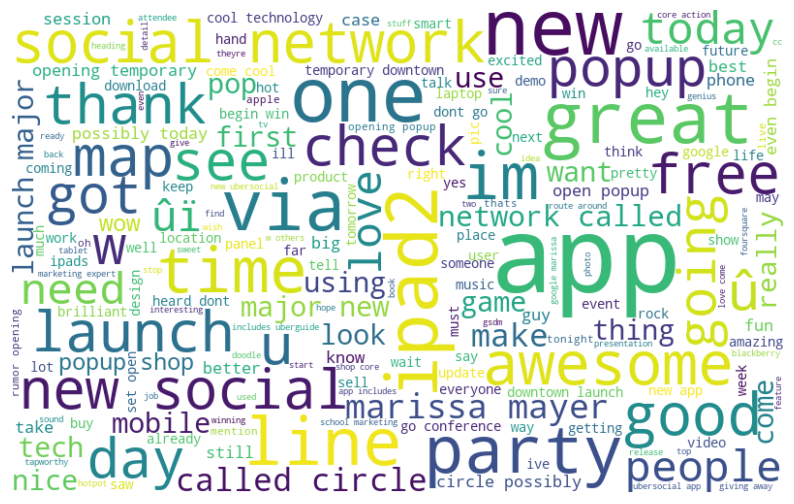

In [338]:
tweet_cloud(df_pos)

Neutral tweet word cloud

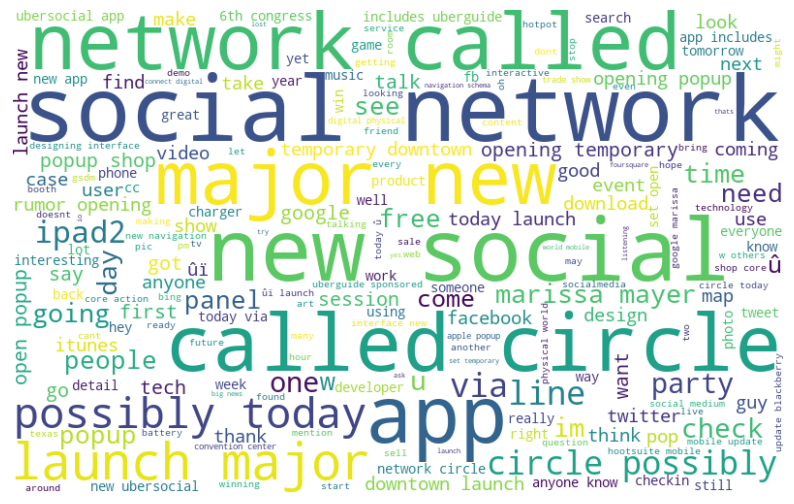

In [339]:
tweet_cloud(df_neu)

Emotion distribution for google and apple

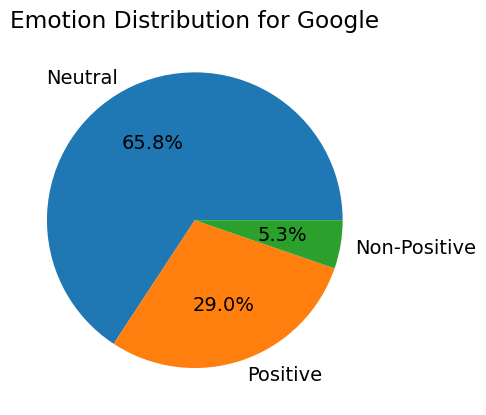

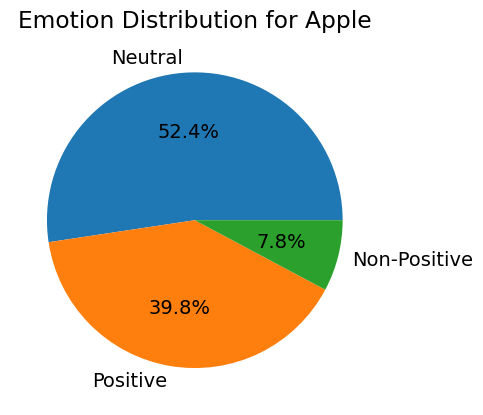

In [340]:
# Filter the DataFrame for Google and Apple
df_google = df[df['brand'] == 'Google']
df_apple = df[df['brand'] == 'Apple']

# Count the number of emotions for Google and Apple
google_emotions = df_google['emotion'].value_counts()
apple_emotions = df_apple['emotion'].value_counts()

# Create a pie chart for Google
fig, ax = plt.subplots()
ax.pie(google_emotions, labels=google_emotions.index, autopct='%1.1f%%')
ax.set_title("Emotion Distribution for Google")
plt.show()

# Create a pie chart for Apple
fig, ax = plt.subplots()
ax.pie(apple_emotions, labels=apple_emotions.index, autopct='%1.1f%%')
ax.set_title("Emotion Distribution for Apple")
plt.show()

## Modeling

### Preparation

In [341]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc)
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import seaborn as sns


model_df = df.copy()
#converting token lists to a string
model_df['text_str'] = model_df['text'].apply(lambda tokens: ' '.join(tokens))
#drop brand and text columns
model_df.drop(['brand', 'text'], axis=1, inplace=True)
model_df.rename(columns={'text_str':'text'}, inplace=True)
model_df = model_df[model_df.emotion != 'Neutral']

model_df.head()

,emotion,text
0,Non-Positive,3g hr tweeting riseaustin dead need upgrade pl...
1,Positive,know awesome app likely appreciate design also...
2,Positive,not wait also sale
3,Non-Positive,hope year festival isnt crashy year app
4,Positive,great stuff fri marissa mayer tim oreilly tech...


Checking the distribution of emotions

In [342]:
model_df.emotion.value_counts()

emotion
Positive        2960
Non-Positive     568
Name: count, dtype: int64

We can see a clear class imbalance. We will use SMOTE to oversample the minority class.

Label Encode emotion labels

In [343]:
label_encoder = LabelEncoder()
model_df['emotion_encoded'] = label_encoder.fit_transform(model_df['emotion'])
model_df.drop(['emotion'], axis=1, inplace=True)
model_df.rename(columns={'emotion_encoded':'emotion'}, inplace=True)
model_df

,text,emotion
0,3g hr tweeting riseaustin dead need upgrade pl...,0
1,know awesome app likely appreciate design also...,1
2,not wait also sale,1
3,hope year festival isnt crashy year app,0
4,great stuff fri marissa mayer tim oreilly tech...,1
...,...,...
9077,pr guy convinced switch back great coverage pr...,1
9079,papyrus sort like nice lol lavelle,1
9080,diller say tv might run over playstation xbox ...,0
9085,ive always used camera b c image stabilizer mo...,1


### Vectorize and split dataframe

In [344]:
X = model_df.text
Y = model_df.emotion
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print("train: ",(X_train.shape, y_train.shape),"\ntest", (X_test.shape, y_test.shape))


train:  ((3175, 23302), (3175,)) 
test ((353, 23302), (353,))


Usinf SMOTE resampling to adress the class imbalance.

In [345]:
smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

#### Model Testing

Create a function to test the model and print the classification report and confusion matrix

In [346]:
def test_model(model, xp = [X_train, X_test], yp=[y_train, y_test]):
    mt_x, mt_y = xp[0],yp[0]
    mt_xtest, mt_ytest = xp[1],yp[1]
    model.fit(mt_x, mt_y)
    y_pred = model.predict(mt_xtest)
    cf=classification_report(mt_ytest,y_pred)
    print(f"Score: {model.score(mt_xtest, y_test)*100:.2f}%")
    print(cf)
    #show heatmap for predictions
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual values")
    plt.show()



Trying Naive Bayes

Score: 87.25%
              precision    recall  f1-score   support

           0       0.48      0.67      0.56        43
           1       0.95      0.90      0.93       310

    accuracy                           0.87       353
   macro avg       0.72      0.79      0.74       353
weighted avg       0.90      0.87      0.88       353



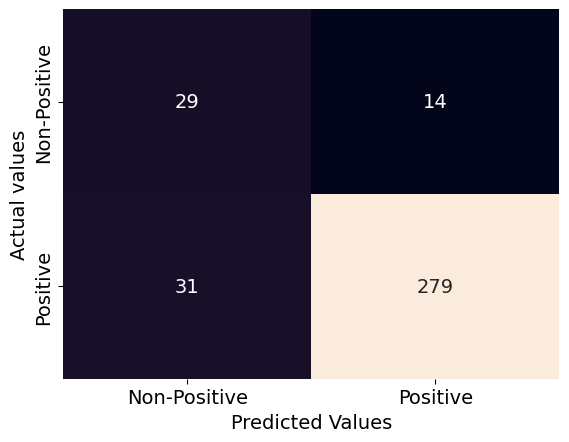

In [347]:
mnb=MultinomialNB()
test_model(mnb)

Trying LinearSVC

Score: 89.80%
              precision    recall  f1-score   support

           0       0.64      0.37      0.47        43
           1       0.92      0.97      0.94       310

    accuracy                           0.90       353
   macro avg       0.78      0.67      0.71       353
weighted avg       0.88      0.90      0.89       353



/home/ian/dev/anaconda/envs/dev/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


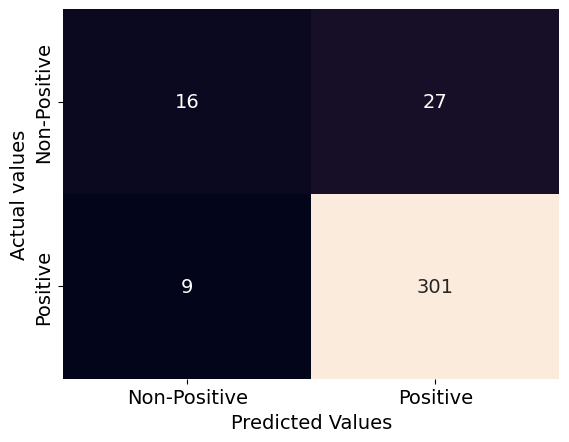

In [348]:
from sklearn.calibration import LinearSVC


SVCmodel = LinearSVC()
test_model(SVCmodel)

Trying Logistic Regression

Score: 90.08%
              precision    recall  f1-score   support

           0       0.63      0.44      0.52        43
           1       0.93      0.96      0.94       310

    accuracy                           0.90       353
   macro avg       0.78      0.70      0.73       353
weighted avg       0.89      0.90      0.89       353



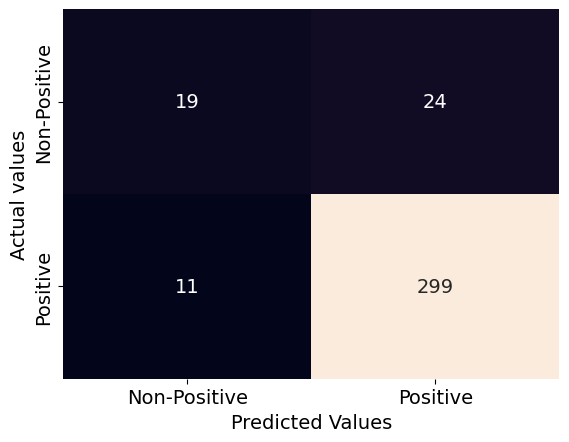

In [349]:
from sklearn.linear_model import LogisticRegression


LRmodel = LogisticRegression()
test_model(LRmodel)

#### Observations
Given the class imbalnce showing class 0 (Non-positive) to be vastly the minirority class, Naive Bayes is performing well, identifying class 0 with 70% recall

Best Parameters:  {'alpha': 0.1, 'class_prior': [0.2, 0.8], 'fit_prior': True}
Score: 90.65%
              precision    recall  f1-score   support

           0       0.71      0.40      0.51        43
           1       0.92      0.98      0.95       310

    accuracy                           0.91       353
   macro avg       0.81      0.69      0.73       353
weighted avg       0.90      0.91      0.89       353



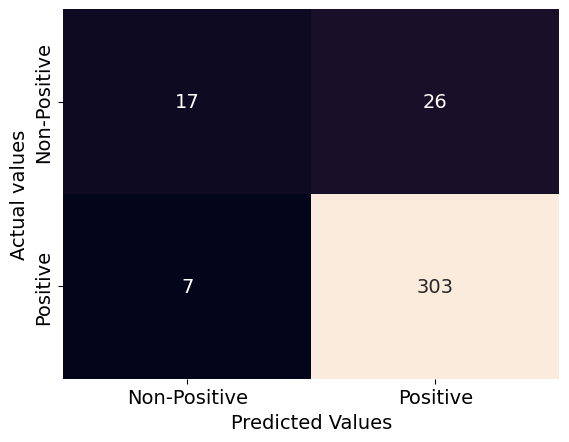

In [350]:
# Define the parameter grid
param_grid = {
    'alpha': [0.1, 1, 10, 100],
    'fit_prior': [True, False],
    'class_prior': [None, [0.5, 0.5], [0.2, 0.8]],
}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
best_model_mnb = MultinomialNB(**grid_search.best_params_)
test_model(best_model_mnb)

#### Observations
Gridsearch for the Multinomial model outperforms the initial Naive Bayes model, showing better recall and precision for Non-positive class.

#### Neural Network
The next step is to build a Neural Network model using Keras. The first task is to preprocess the text data.

In [351]:
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.discriminant_analysis import StandardScaler



nn_df = model_df.copy()
max_words = 100000  # Number of unique words to keep
max_len = 1000      # Maximum length of sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(nn_df.text)
sequences = tokenizer.texts_to_sequences(nn_df.text)

# Pad sequences
X_nn = pad_sequences(sequences)
y_nn = nn_df.emotion

The model is then defined with relu activation, two layers, and a sigmoid activation for binary classification.

In [352]:
from keras.regularizers import l2
from keras.layers import Dropout

# Initialize a sequential model
nn = Sequential()

# Two layers with relu activation
nn.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
nn.add(Dense(25, activation='linear'))

# Output Layer with sigmoid activation for binary classification
nn.add(Dense(1, activation='sigmoid'))
# Compile the model
nn.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['acc'])

The model is then trained with early stopping to prevent overfitting.

In [353]:
# Split data
from keras.callbacks import EarlyStopping


X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)


history = nn.fit(X_train,
                y_train,
                epochs=50,
                batch_size=128,
                callbacks=[EarlyStopping(monitor='acc', patience=5)],)

Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 1.0730 - acc: 0.5514
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.9235 - acc: 0.5917
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.8297 - acc: 0.6103
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7688 - acc: 0.6171
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.7250 - acc: 0.6279
Epoch 6/50
37/37 [==============================] - 0s 11ms/step - loss: 0.6995 - acc: 0.6306
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6747 - acc: 0.6486
Epoch 8/50
37/37 [==============================] - 0s 8ms/step - loss: 0.6661 - acc: 0.6504
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6535 - acc: 0.6643
Epoch 10/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6459 - acc: 0.6622
Epoch 11/50
37/37 [==============================] - 0s 6ms/step - l

The model is then evaluated on the test set.

In [354]:
# Output (probability) predictions for the test set 
y_hat_test = nn.predict(X_test) 
# Print the loss and accuracy for the training set 
results_train = nn.evaluate(X_train, y_train)
print("Train\n",results_train,"\n----------------------------")


# Print the loss and accuracy for the test set
loss, accuracy = nn.evaluate(X_test, y_test, verbose=1)
print(f"Validation Loss: {loss*100:.2f}%")
print(f"Validation Accuracy: {accuracy*100:.2f}%")


148/148 [==============================] - 1s 3ms/step - loss: 0.5129 - acc: 0.7621
Train
 [0.5129268169403076, 0.7620660662651062] 
----------------------------
23/23 [==============================] - 0s 4ms/step - loss: 0.6896 - acc: 0.6799
Validation Loss: 68.96%
Validation Accuracy: 67.99%


Then we plot the confusion matrix and classification report to further analyze the model's performance.

              precision    recall  f1-score   support

           0       0.19      0.32      0.24       108
           1       0.86      0.74      0.80       598

    accuracy                           0.68       706
   macro avg       0.52      0.53      0.52       706
weighted avg       0.76      0.68      0.71       706



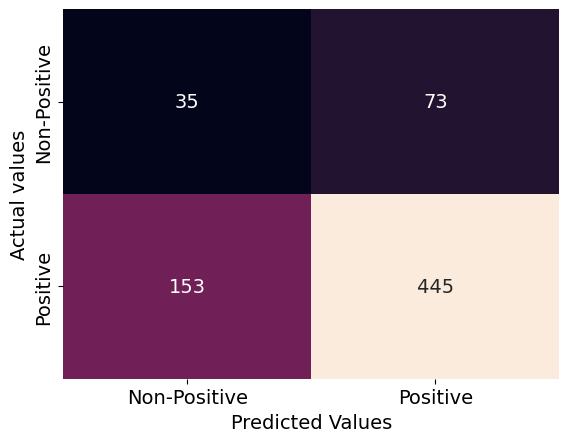

In [355]:
y_pred_classes = (y_hat_test > 0.5).astype(int)
# Print classification report
print(classification_report(y_test, y_pred_classes))

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Values")
plt.ylabel("Actual values")
plt.show()

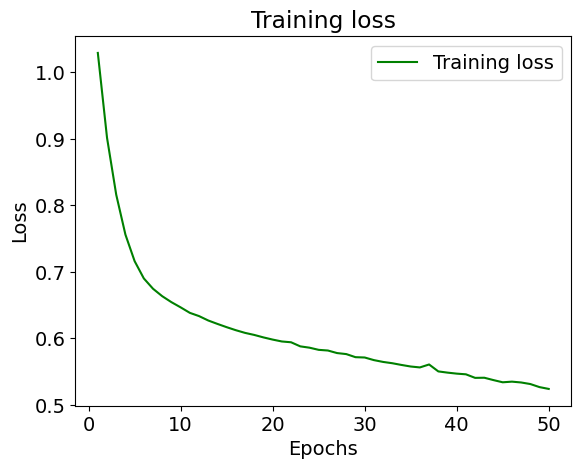

In [356]:
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

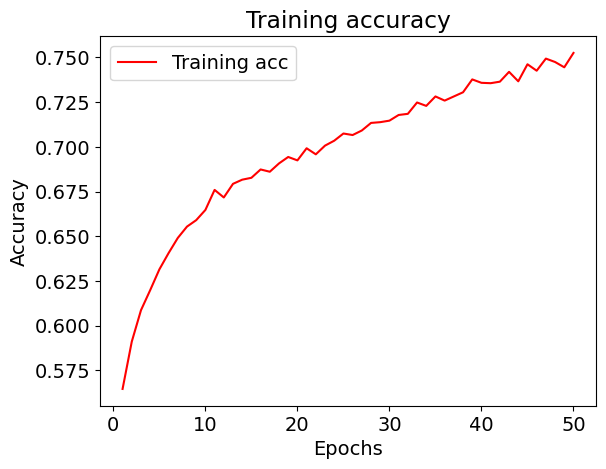

In [357]:
# Plot the training accuracy vs the number of epochs

acc_values = history_dict['acc'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Observations
The model does not perform well on this dataset, showing lower accuracy and recall for the Non-positive class. This might be due to the imbalance in the dataset and the small size of the dataset. With more data and a larger dataset, the model's performance would be better.
### Selecting the best model
The Naive Bayes model, with SMOTE resampling, performs well on this dataset given the class imbalance. It achieves a 70% recall for the Non-positive tweets. It is selected as the best model for this task and saved for deployment.

In [358]:
import pickle
with open('mnb_model.pkl', 'wb') as file:
    pickle.dump(mnb, file)

The Vectorizor is also saved for consistency in vectorization of the text data.

In [359]:
with open('tfidvectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


## Evaluation
The Naive Bayes model is chosen to be deployed to the demostration. Below is a breakdown of its performance. We will review several metrics including accuracy, precision, recall and F1-score to understand how well the model performs and identify areas for improvement.

### 1. **Evaluation Metrics**

**Overall Accuracy:**  
The model achieves an accuracy of **87.25%**, meaning it correctly classifies 87.25% of the tweets.

**Precision, Recall, and F1-Score:**  
Here’s the detailed performance of the model for each class:

- **Class 0 (Negative Sentiment):**
  - **Precision:** 0.48
  - **Recall:** 0.67
  - **F1-Score:** 0.56
  - **Support:** 43 samples

- **Class 1 (Positive Sentiment):**
  - **Precision:** 0.95
  - **Recall:** 0.90
  - **F1-Score:** 0.93
  - **Support:** 310 samples

**Macro Average:**
  - **Precision:** 0.72
  - **Recall:** 0.79
  - **F1-Score:** 0.74

**Weighted Average:**
  - **Precision:** 0.90
  - **Recall:** 0.87
  - **F1-Score:** 0.88

### 2. **Performance Analysis**

- **Class-wise Performance:**
  - The model performs very well on the positive sentiment class (Class 1), with high precision (0.95), recall (0.90), and F1-score (0.93). This indicates that the model is highly effective at identifying positive sentiments.
  - However, the performance on the negative sentiment class (Class 0) is weaker, with precision at 0.48, recall at 0.67, and F1-score at 0.56. This suggests that the model struggles to accurately identify negative sentiments compared to positive ones.

- **Overall Performance:**
  - The model has high overall accuracy (87.25%) and weighted averages for precision, recall, and F1-score are quite strong. This indicates that despite the model’s struggle with negative sentiment classification, it still performs well overall due to the higher number of positive sentiment tweets.

### 3. **Model Limitations**

- **Bias Towards Positive Sentiment:**
  - The model shows a significant bias towards positive sentiment due to the imbalance in the dataset (more positive samples). 

- **Data Representation:**
  - If negative sentiments are underrepresented in the training data, the model might struggle with identifying such sentiments accurately.

### 4. **Suggestions for Improvement**

- **Data Augmentation:**
  - Increase the representation of negative sentiment examples in the training dataset to help the model learn better characteristics of negative sentiments.
  - Consider techniques like data synthesis. By using existing tweets and applying sentiment analysis techniques to generate synthetic negative examples, a more robust dataset could be created.

## Conclusion
The sentiment analysis model demonstrates strong performance in classifying positive sentiments but needs improvement in accurately identifying negative sentiments. Addressing the imbalance in the dataset could enhance overall performance. The substantial difference in performance between positive and negative sentiment necessitates improving classification for negative sentiment.